# Predictions on Time Series with Prescience

The best way to understand how to make prediction on timeseries in `Prescience` is probably to do it with an example. For that purpose we are going to use a well known dataset `International airline passengers` which indicate the frequentation of passengers of international airports between January 1949 and December 1960. 

The original data is available on [datamarket](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line).

## Initial Data Analysis

We previously downloaded locally the file containing data as csv. Let's have a look at what is inside the first 10 rows.

In [14]:
# Local directory in which we saved the data
INPUT = 'data/passengers-date.csv'
# Our local data is a CSV and has a header row
HAS_HEADER = True

import pandas
from IPython.core.display import HTML
INITIAL_DATAFRAME = pandas.read_csv(INPUT)
HTML(INITIAL_DATAFRAME.head(10).to_html())

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


We can see that the initial data is composed of 2 columns :
* `month` : The step number in the dataset
* `passengers` : The number of passengers (in thousands) per steps

## Upload on Prescience and parse the data

Now that we had a first look locally on our data, let's upload it on prescience.

When we upload data on prescience, it automatically starts a `parse task`. A `parse task` is responsible for doing some pre-analysis on your data by creating a `source` object.

In [15]:
from prescience_client import prescience
import matplotlib

# We create a local file input from our csv file
csv_input = prescience.csv_local_file_input(INPUT, headers=HAS_HEADER)
# We start a parse task on prescience and watch for it (i.e we wait until the task ends)
parse_task = csv_input.parse(source_id='passengers').watch()
# We get back the created source from the finished task
source = parse_task.source()
# We display the computed sources statistics of the schema
source.schema().show('html')

Uploading source with following arguments :
{
    "source_id": "passengers",
    "type": "CSV",
    "headers": true,
    "separator": "COMMA"
}
Task parse 75858182-ec17-4a1b-9918-6982c4900362 DONE


,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,month,string,True,144,None,None,0.0,1960-08,True
1,passengers,integer,True,118,None,None,264.0,229,True


As you can see in the previous table, the `parse` task correctly the schema of your data as well as some statistics about it.

Moreover you can now see your source object available when you asks to list all the sources of your project:

In [16]:
# Display the list of all sources in your prescience project
prescience.sources().show('html')

,source_id,status,input_type,info
0,passengers,BUILT,CSV,None


You can even plot your source object if you want to visually see your timeserie. For doing so you will just need to indicate the name of the column used as `x`.

Updating cache for source 'passengers' : /tmp/.prescience/cache/sources/passengers


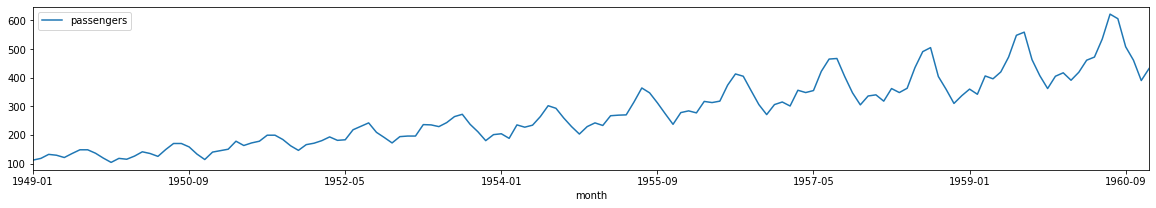

In [17]:
%matplotlib inline
import matplotlib
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)
source.plot(x='month')

## Problem Definition

Now we want to be able to make predictions based on this time-series and we want to let prescience infer the predictive model for us. For that purpose, we are going to start an `auto-ml task` after defining problem's metadata.

### The problem type

It is the problem that we want to solve. In this case it's a `time_series_forecast`.

In [18]:
PROBLEM_TYPE = 'time_series_forecast'

### The time column
It is the column in your initial data that indicates time or step of your time-series. It should be a `integer number`. In our case, it is the `month` column.

In [19]:
TIME_COLUMN = 'month'

### The label column
It the the column that you want to predict. In our case, it is the `passengers` column.

In [20]:
LABEL_COLUMN = 'passengers'

### The horizon
The horizon is the number of steps that you want to predict in the future. In our case it is arbitrary but for the demonstration we are going to chose a horizon of 12 steps.

In [21]:
HORIZON = 12

### The scoring metric
It is the metric that we want to use to evaluate the relevance of trained models. In case of `time_series_forecast` the `mean square error` (short: `mse`) is a good metric.

In [22]:
SCORING_METRIC = 'mse'

### The number of fold
It is the number of part in which your time-series will be split to evaluate the relevance of trained model. In our case we dont' have so many rows in out initial data so we are going to choose a small number : `2`

In [23]:
NB_FOLD = 2

## Start the Automated Machine Learning Task
With all the previous information we can start the auto-ml task and wait for it to complete (This can take some times). We will see later that this task creates 2 objects : a `dataset` and a `model` that's why the functions returns a task and 2 identifiers.

In [25]:
# Start an AUTO-ML task
task, dataset_id, model_id = source.start_auto_ml(
    label_id=LABEL_COLUMN,
    problem_type=PROBLEM_TYPE,
    time_column=TIME_COLUMN,
    forecasting_horizon_steps=HORIZON,
    scoring_metric=SCORING_METRIC,
    nb_fold=NB_FOLD,
    formatter='yyyy-MM',
    datetime_exogenous=[],
    granularity='month'
)
task.watch()

Starting AutoML task with following arguments :
{
    "dataset_id": "passengers_dataset_RMDZEWV",
    "label_id": "passengers",
    "model_id": "passengers_model_RMDZEWV",
    "problem_type": "time_series_forecast",
    "scoring_metric": "mse",
    "custom_parameters": {},
    "optimization_method": "SMAC",
    "multiclass": false,
    "time_column_id": "month",
    "nb_fold": 2,
    "forecasting_horizon_steps": 12,
    "datetime_info": {
        "format": "yyyy-MM",
        "exogenous": [],
        "granularity": "month"
    }
}
Task model-metrics e2094a3b-0b34-4e75-839d-3df6bd278935 DONE


The finality of an `auto-ml task` is to automatically find and deploy a `model` that makes correct predictions based on you initial data. You can access it by its `model_id`.

In [26]:
# Access the created model on prescience
model = prescience.model(model_id)

## Observing predictions results
Ploting the predicted result of a model is one of the best way to estimate its relevancy. We are goin to choose some arbitrary points in our original data and compare the theorical serie with the predicted one from newly deployed model.

In [27]:
STEP_TO_PREDICT = '1959-01'

# Generate the input payload that will be send to the model for making prediction (it use the initial data to create it)
payload_dict = prescience.generate_payload_dict_for_model(model_id, from_data=STEP_TO_PREDICT)

# Print this payload :
import json
print(json.dumps(payload_dict, indent=4))

Cache for source 'passengers' is already up to date on /tmp/.prescience/cache/sources/passengers
Directory '/tmp/.prescience/cache/payload' doesn't exists. Creating it...
Saving json into `/tmp/.prescience/cache/payload/payload.json`
{
    "month": [
        "1958-05",
        "1958-06",
        "1958-07",
        "1958-08",
        "1958-09",
        "1958-10",
        "1958-11",
        "1958-12",
        "1959-01"
    ],
    "passengers": [
        363,
        435,
        491,
        505,
        404,
        359,
        310,
        337,
        360
    ]
}


### Ask for a single prediction

Cache for source 'passengers' is already up to date on /tmp/.prescience/cache/sources/passengers


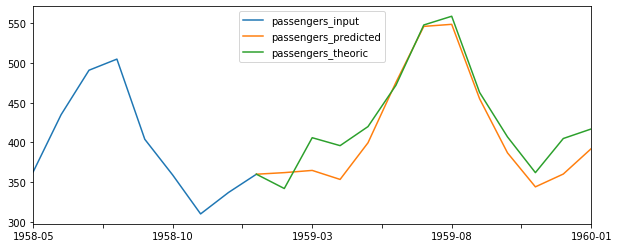

In [28]:
# Get the prediction of the model
result_dataframe = model.get_dataframe_for_plot_result(payload_dict)

# Plot the prediction of the model
matplotlib.pyplot.rcParams["figure.figsize"] = (10, 4)
result_dataframe.plot()

### Ask for a rolling prediction

Cache for source 'passengers' is already up to date on /tmp/.prescience/cache/sources/passengers


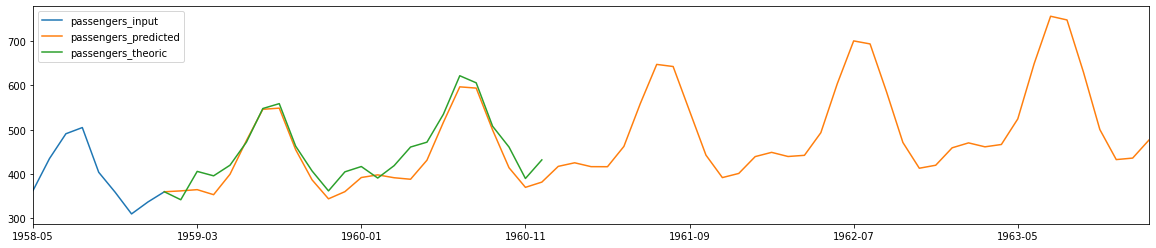

In [29]:
# Get the prediction of the model with a 'rolling' strategy
result_dataframe = model.get_dataframe_for_plot_result(payload_dict, rolling_steps=4)

# Plot the prediction of the model
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 4)
result_dataframe.plot()

As you can see, it seems that the deployed model unsterstood the trend and the seasonality of the underlying time-series. It is a first step, however predictions can be improved. We are going to see what is really happening under the hood and try to improve that prediction.

## Under the hood

As already told before, an auto-ml tasks start from a source object and creates 2 other objects, first a dataset and then a model. You can see the relationship between each other by doing so : 

In [30]:
source.tree().show()

/prescience-client/prescience_client/config/prescience_config.py:101: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  loaded_config = yaml.load(stream)


Source(passengers)
 +-- Dataset(passengers_dataset_RMDZEWV)
     +-- Model(passengers_model_RMDZEWV)


### The Source object

The source object is almost like your original data, except that it holds some metadata inside that have been computed during the parse tasks. We wont describe all the metadata here but this is several statistics like :
* The standard deviation for each column
* The type of data contained in the column (integer, boolean, text, etc...)
* If the column can contains `null` values
* etc...

You can see the computed statistic on your source by doing so :

In [31]:
source.schema().show('html')

,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,month,string,True,144,None,None,0.0,1960-08,True
1,passengers,integer,True,118,None,None,264.0,229,True


### The dataset object

The `dataset` object contains the same data than in your `source` except that this data has been transformed so that it can be understandable by machine learning algorithms.

The rules of transformation won't be described here but all you have to know is that previously computed statistics are used to choose the good transformation strategy.

In our case if we plot the dataset we will see that it looks exactly the same as the source, except that all axis have been standardized (i.e values have been rescaled and bound with 0 as the mean)

Directory '/tmp/.prescience/cache/datasets' doesn't exists. Creating it...
Directory '/tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/train' doesn't exists. Creating it...
Updating cache for source 'passengers_dataset_RMDZEWV' : /tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/train


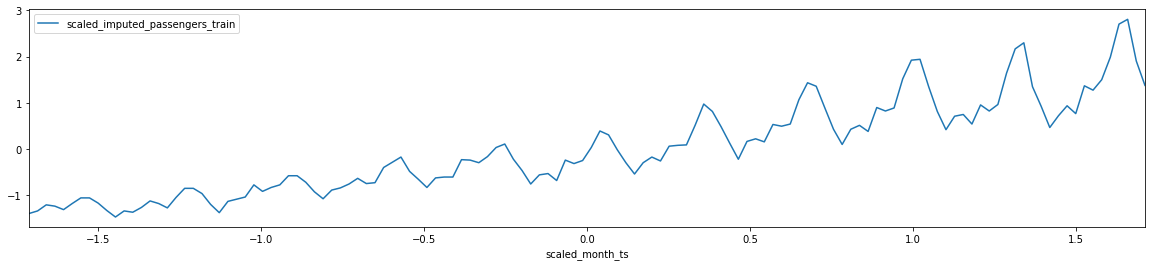

In [32]:
prescience.plot_dataset(dataset_id, plot_test=False)

The `dataset` object is created from a `source` with a `preprocess task`. Another things to note is that the preprocess task is responsible for creating the `folds` that we previously talk about on `Problem Definition` part.

You wan easily see created `folds` :

Directory '/tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/0/train' doesn't exists. Creating it...
Updating cache for source 'passengers_dataset_RMDZEWV' : /tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/0/train
Directory '/tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/0/test' doesn't exists. Creating it...
Updating cache for source 'passengers_dataset_RMDZEWV' : /tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/0/test


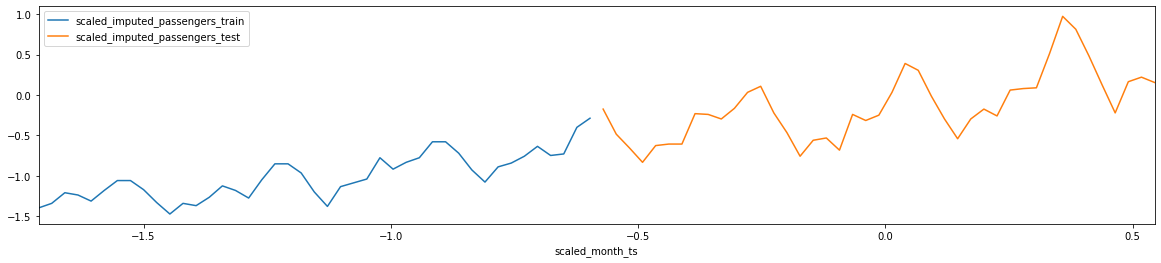

Directory '/tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/1/train' doesn't exists. Creating it...
Updating cache for source 'passengers_dataset_RMDZEWV' : /tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/1/train
Directory '/tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/1/test' doesn't exists. Creating it...
Updating cache for source 'passengers_dataset_RMDZEWV' : /tmp/.prescience/cache/datasets/passengers_dataset_RMDZEWV/fold/1/test


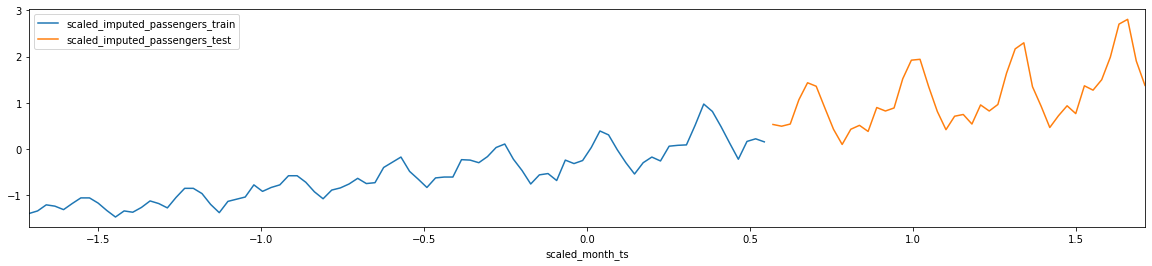

In [33]:
for fold_number in range(NB_FOLD):
    prescience.plot_dataset(dataset_id, fold_number=fold_number)

As you can see, each fold is composed of 2 parts :
* A train part which is used to train machine learning algorithms
* A test part which is used to evalute the relevance of a model

It is a standard process in machine learning in order to evaluate relevancy of machine learning algorithms on data that they have never seen before.

### The model object

The `model` object is created from a `dataset` with a `train task` however a train task needs to be launched on a specific machine learning algorithm with defined parameters. That's why there is an intermediate task which is called the `optimization task`.

The aim of an optimization task is to use the previously created folds of our dataset to train a lot of machine learning algorithms with different hyperparameters, evaluate them and find the best.

All results of evaluations are stored in prescience into objects called `evaluations results`. You can request the visualisation of previously computed evaluation by doing so :

In [34]:
evaluation_results = prescience.get_evaluation_results(
    dataset_id,
    # Only display results for the wanted horizon
    forecasting_horizon_steps=HORIZON,
    # Sort all the results by the selected scoring metric
    sort_column=f'costs.{SCORING_METRIC}'
)
evaluation_results.show('html')

,uuid,status,config_name,past_steps,horizon,discount,mape_cost,r2_cost,mae_cost,mse_cost
0,c85b2138-0f5d-4488-953f-696c1743f3ec,BUILT,skridgeregression,9,12,1.0,98.261,-0.392,0.294,0.139
1,10419a47-a9b5-4f97-80b0-9254ad6363e7,BUILT,lstm_for_time_series,15,12,1.0,118.999,0.742,0.487,0.448
2,8b076356-08cb-4e47-99d6-beb9d901d8fe,BUILT,lstm_for_time_series,23,12,1.0,171.560,0.870,0.521,0.482
3,1db44fa2-972a-447f-955f-afb1f53edf0c,BUILT,mlp_for_time_series,28,12,1.0,132.804,1.928,0.682,0.819
4,e04d90f0-a3ec-4ea1-ae75-66da7d52c465,BUILT,mlp_for_time_series,15,12,1.0,182.484,2.463,0.733,0.969
5,964233f8-3133-45b9-9cfb-bf9ecd038132,BUILT,skridgeregression,15,12,1.0,749.316,19.195,1.175,2.724


The first row of the table is the best model and configuration find. If we compare this configuration with the configuration of the model deployed we will see that they are the same.

In [35]:
# Show the config from the best evaluation results
config_eval = evaluation_results.content[0].config()
print(config_eval.kwargs())
config_eval.show('html')

{'alpha': 0.4435176946347249, 'normalize': 'False', 'past_steps': 9, 'fit_intercept': 'True', 'forecasting_discount': 1.0, 'forecasting_horizon_steps': 12}


,,CONFIG attributes
0,name,skridgeregression
1,display_name,Ridge Regression
2,class_identifier,linear_model.Ridge
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'alpha': 0.4435176946347249, 'normalize': 'Fa..."


In [36]:
# Show the config from the 
config_train = model.config()
print(config_train.kwargs())
config_train.show('html')

{'alpha': 0.4435176946347249, 'normalize': 'False', 'past_steps': 9, 'fit_intercept': 'True', 'forecasting_discount': 1.0, 'forecasting_horizon_steps': 12}


,,CONFIG attributes
0,name,skridgeregression
1,display_name,Ridge Regression
2,class_identifier,linear_model.Ridge
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'alpha': 0.4435176946347249, 'normalize': 'Fa..."
